## https://www.youtube.com/watch?v=0qtvb_Nx2tA
https://www.youtube.com/watch?v=H9H6s-x-0YE

https://www.youtube.com/watch?v=abF_FdCb5OI


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sys import getsizeof
from keras.datasets import mnist
import time

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

sels = np.where(np.logical_or(y_train==1, y_train==5))[0]
x_train = x_train[sels,:,:].reshape(-1,784)
y_train = y_train[sels]

Using TensorFlow backend.
/Users/RomanKoshkin/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
input_dim = 784
output_dim = 2
train_set_size = x_train.shape[0]
w = np.random.rand(input_dim, output_dim)
print('Weight matrix size:\t{:.2f}MB'.format(np.round(getsizeof(w)/1024/1024, 2), ))
print('Training set size:\t{:d}'.format(train_set_size))

Weight matrix size:	0.01MB
Training set size:	12163


In [3]:
def dw(w, t, I):
    dw_ = np.zeros((input_dim, output_dim))
    for j in range(input_dim):
        for i in range(output_dim):
            dw_[j,i] = eta(t)*T(i,I,t)*(x[j] - w[j,i])
    return dw_

def get_I(x,w, output_dim):
    d = np.zeros(output_dim,)
    for i in range(output_dim):
        d[i] = np.linalg.norm(x-w[:,i])
    return np.argmin(d), d
    
def sigma(t):
    sigma0 = 10
    tau_sigma = 30
    return sigma0 * np.exp(-t/tau_sigma)
        
def eta(t):
    eta0 = 0.05
    tau_eta = 40
    return eta0*np.exp(-t/tau_eta)

def T(i, I, t):
    return np.exp(-(S(i,I,w))**2/(2*(sigma(t))**2)) 

def S(i, I, w):
    return np.linalg.norm(w[:,i] - w[:,I]) # possibly not norm, 


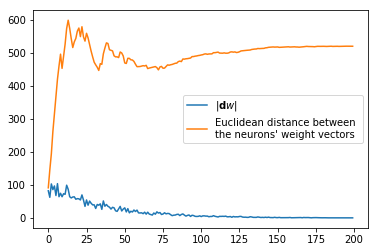

In [4]:
w = np.random.randn(input_dim, output_dim)
W, DIST = [], []
for t in range(200):
    choice = np.random.choice(train_set_size)
    x = x_train[choice, :].reshape(-1,1)
    I, d = get_I(x, w, output_dim)
    dw_ = dw(w, t, I)
    W.append(np.linalg.norm(dw_))
    w += dw_
    dist = np.linalg.norm(w[:,0]-w[:,1])
    DIST.append(dist)
plt.plot(W)
plt.plot(DIST)
plt.legend(['$|\mathbf{d}w|$', 'Euclidean distance between \nthe neurons\' weight vectors'])

In [5]:
out = []
mean1 = (1, 1)
mean2 = (5, 5)
cov = [[1, 0], [0, 1]]
for choice in range(400):
    pred, _ = get_I(x_train[choice], w, output_dim)
    if pred==0:
        out.append(np.random.multivariate_normal(mean1, cov, 1))
    else:
        out.append(np.random.multivariate_normal(mean2, cov, 1))
    
    print('Choice: {:d} \t Class: {:d}\tPred: {:d}\t {}'.format(choice, int(y_train[choice]), int(pred),
                                                           ['correct' if
                                                            (y_train[choice] == 5 and pred==0) or
                                                            (y_train[choice] == 1 and pred==1) else 'Wrong']))
out = np.vstack(out)

Choice: 0 	 Class: 5	Pred: 0	 ['correct']
Choice: 1 	 Class: 1	Pred: 1	 ['correct']
Choice: 2 	 Class: 1	Pred: 1	 ['correct']
Choice: 3 	 Class: 1	Pred: 1	 ['correct']
Choice: 4 	 Class: 5	Pred: 1	 ['Wrong']
Choice: 5 	 Class: 1	Pred: 1	 ['correct']
Choice: 6 	 Class: 1	Pred: 1	 ['correct']
Choice: 7 	 Class: 1	Pred: 0	 ['Wrong']
Choice: 8 	 Class: 5	Pred: 1	 ['Wrong']
Choice: 9 	 Class: 1	Pred: 1	 ['correct']
Choice: 10 	 Class: 5	Pred: 0	 ['correct']
Choice: 11 	 Class: 1	Pred: 1	 ['correct']
Choice: 12 	 Class: 5	Pred: 1	 ['Wrong']
Choice: 13 	 Class: 1	Pred: 1	 ['correct']
Choice: 14 	 Class: 1	Pred: 0	 ['Wrong']
Choice: 15 	 Class: 1	Pred: 1	 ['correct']
Choice: 16 	 Class: 1	Pred: 1	 ['correct']
Choice: 17 	 Class: 1	Pred: 1	 ['correct']
Choice: 18 	 Class: 1	Pred: 1	 ['correct']
Choice: 19 	 Class: 5	Pred: 0	 ['correct']
Choice: 20 	 Class: 1	Pred: 1	 ['correct']
Choice: 21 	 Class: 1	Pred: 1	 ['correct']
Choice: 22 	 Class: 1	Pred: 1	 ['correct']
Choice: 23 	 Class: 1	Pred: 1	 

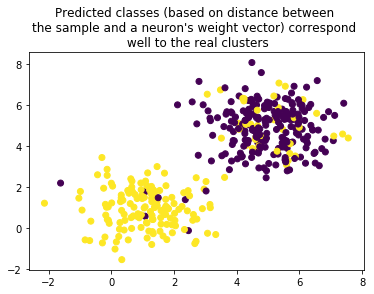

In [6]:
plt.title('Predicted classes (based on distance between \nthe sample and a neuron\'s weight vector) correspond \n well to the real clusters') 
plt.scatter(out[:,0], out[:,1], c=y_train[0:400])

## Now let's do the same using an autoencoder with a 2D latent space:

In [9]:
from keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, UpSampling2D, SeparableConv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras import backend as K


def Encoder():
    input_img = Input(shape=(784,))  # adapt this if using `channels_first` image data format   
    e1 = Dense(2, activation='sigmoid')(input_img)
    return Model(input_img, e1, name='encoder')

def Decoder():
    input_img = Input(shape=(2,))  # adapt this if using `channels_first` image data format   
    e1 = Dense(784, activation='sigmoid')(input_img)
    return Model(input_img, e1, name='decoder')

encoder = Encoder()
decoder = Decoder()

inpt = Input(shape=(784,))
autoenc = Model(inputs=inpt, outputs=decoder(encoder(inpt)))
autoenc.compile(optimizer='adam', loss='mse')
h = autoenc.fit(x_train, 
                x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                verbose=1)

Epoch 1/100
12163/12163 [==============================] - 1s 60us/step - loss: 5483.0543
Epoch 2/100
12163/12163 [==============================] - 1s 47us/step - loss: 5478.7299
Epoch 3/100
12163/12163 [==============================] - 1s 47us/step - loss: 5475.0245
Epoch 4/100
12163/12163 [==============================] - 1s 49us/step - loss: 5472.0336
Epoch 5/100
12163/12163 [==============================] - 1s 52us/step - loss: 5469.7079
Epoch 6/100
12163/12163 [==============================] - 1s 49us/step - loss: 5467.9305
Epoch 7/100
12163/12163 [==============================] - 1s 50us/step - loss: 5466.5678
Epoch 8/100
12163/12163 [==============================] - 1s 49us/step - loss: 5465.5192
Epoch 9/100
12163/12163 [==============================] - 1s 49us/step - loss: 5464.7018
Epoch 10/100
12163/12163 [==============================] - 1s 64us/step - loss: 5464.0561
Epoch 11/100
12163/12163 [==============================] - 1s 55us/step - loss: 5463.5372
Epoch 12

12163/12163 [==============================] - 1s 46us/step - loss: 5460.4050
Epoch 92/100
12163/12163 [==============================] - 1s 45us/step - loss: 5460.4042
Epoch 93/100
12163/12163 [==============================] - 1s 45us/step - loss: 5460.4037
Epoch 94/100
12163/12163 [==============================] - 1s 46us/step - loss: 5460.4033
Epoch 95/100
12163/12163 [==============================] - 1s 60us/step - loss: 5460.4028
Epoch 96/100
12163/12163 [==============================] - 1s 51us/step - loss: 5460.4025
Epoch 97/100
12163/12163 [==============================] - 1s 54us/step - loss: 5460.4016
Epoch 98/100
12163/12163 [==============================] - 1s 51us/step - loss: 5460.4011
Epoch 99/100
12163/12163 [==============================] - 1s 49us/step - loss: 5460.4006
Epoch 100/100
12163/12163 [==============================] - 1s 48us/step - loss: 5460.4003


Text(0.5,1,'In the latent 2D space, we see that the clusters are not separated at all')

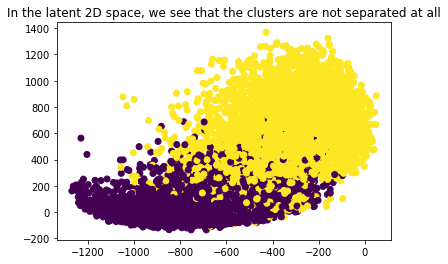

In [8]:
pred = encoder.predict(x_train)
plt.scatter(pred[:,0], pred[:,1], c=y_train)

#### We see that Kohonen works probably better than an autoencoder

## Example 2

In the following example, the Kohonen SOM can't separate the classes well (admitted or not admitted)

In [16]:
# get and preprocess the data:
admit, gre, gpa, rank = [],[],[],[]
with open('dat/binary.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    c = 0
    for row in spamreader:
        result = [x.strip() for x in row[0].split(',')]
        if c > 0:
            admit.append(float(result[0]))
            gre.append(float(result[1]))
            gpa.append(float(result[2]))
            rank.append(float(result[3]))
        c += 1

x_train = np.stack([gre,gpa,rank]).T
# transform data to zero mean and unit variance:
x_train = (x_train-np.mean(x_train,0))/np.std(x_train,0)
y_train = admit


""" 
the function below are the same, just different hyperparameters (tau and sigma)
"""
def dw(w, t, I):
    dw_ = np.zeros((input_dim, output_dim))
    for j in range(input_dim):
        for i in range(output_dim):
            dw_[j,i] = eta(t)*T(i,I,t)*(x[j] - w[j,i])
    return dw_

def get_I(x,w, output_dim):
    d = np.zeros(output_dim,)
    for i in range(output_dim):
        d[i] = np.linalg.norm(x-w[:,i])
    return np.argmin(d), d
    
def sigma(t):
    sigma0 = 2
    tau_sigma = 10
    return sigma0 * np.exp(-t/tau_sigma)
        
def eta(t):
    eta0 = 0.05
    tau_eta = 200
    return eta0*np.exp(-t/tau_eta)

def T(i, I, t):
    return np.exp(-(S(i,I,w))**2/(2*(sigma(t))**2)) 

def S(i, I, w):
    return np.linalg.norm(w[:,i] - w[:,I]) # possibly not norm, 

w = np.random.rand(input_dim, output_dim)
W, DIST = [], []

Weight matrix size 0.00MB


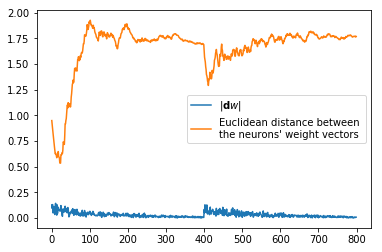

In [18]:
input_dim = 3
output_dim = 2
train_set_size = x_train.shape[0]

print('Weight matrix size {:.2f}MB'.format(np.round(getsizeof(w)/1024/1024, 2), ))


for t in range(400):
    choice = np.random.choice(train_set_size)
#     choice = t
    x = x_train[choice, :].reshape(-1,1)
    I, d = get_I(x, w, output_dim)
    dw_ = dw(w, t, I)
    W.append(np.linalg.norm(dw_))
    w += dw_
    dist = np.linalg.norm(w[:,0]-w[:,1])
    DIST.append(dist)
plt.plot(W)
plt.plot(DIST)
plt.legend(['$|\mathbf{d}w|$', 'Euclidean distance between \nthe neurons\' weight vectors'])

In [19]:
out = []
mean1 = (1, 1)
mean2 = (5, 5)
cov = [[1, 0], [0, 1]]
for choice in range(400):
    pred, _ = get_I(x_train[choice], w, output_dim)
    if pred==0:
        out.append(np.random.multivariate_normal(mean1, cov, 1))
    else:
        out.append(np.random.multivariate_normal(mean2, cov, 1))
    
    print('Choice: {:d} \t Class: {:d}\tPred: {:d}\t {}'.format(choice, int(y_train[choice]), int(pred),
                                                           ['correct' if
                                                            (y_train[choice] == 5 and pred==1) or
                                                            (y_train[choice] == 1 and pred==0) else 'Wrong']))
out = np.vstack(out)

Choice: 0 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 1 	 Class: 1	Pred: 0	 ['correct']
Choice: 2 	 Class: 1	Pred: 0	 ['correct']
Choice: 3 	 Class: 1	Pred: 0	 ['correct']
Choice: 4 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 5 	 Class: 1	Pred: 1	 ['Wrong']
Choice: 6 	 Class: 1	Pred: 1	 ['Wrong']
Choice: 7 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 8 	 Class: 1	Pred: 1	 ['Wrong']
Choice: 9 	 Class: 0	Pred: 0	 ['Wrong']
Choice: 10 	 Class: 0	Pred: 0	 ['Wrong']
Choice: 11 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 12 	 Class: 1	Pred: 0	 ['correct']
Choice: 13 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 14 	 Class: 1	Pred: 0	 ['correct']
Choice: 15 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 16 	 Class: 0	Pred: 0	 ['Wrong']
Choice: 17 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 18 	 Class: 0	Pred: 0	 ['Wrong']
Choice: 19 	 Class: 1	Pred: 0	 ['correct']
Choice: 20 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 21 	 Class: 1	Pred: 0	 ['correct']
Choice: 22 	 Class: 0	Pred: 1	 ['Wrong']
Choice: 23 	 Class: 0	Pred: 0	 ['Wrong']
Choice: 24 	

Text(0.5,1,'In the latent 2D space, we see that the clusters are not separated at all')

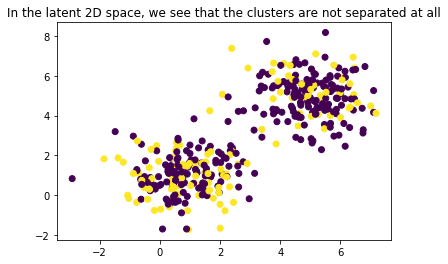

In [21]:
plt.scatter(out[:,0], out[:,1], c=y_train[0:400])
plt.title('In the latent 2D space, we see that the clusters are not separated at all')

## Decaying learning rate
The learning rate $\eta$ decays exponentially from the intitial rate $\eta_0$ with speed $1/\tau_{\eta}$

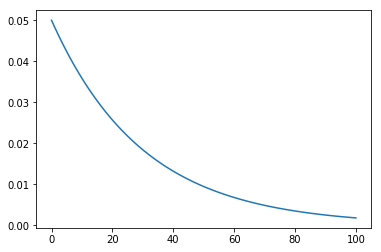

In [22]:
t = np.linspace(0,100,100)
eta0 = 0.05
tau_eta = 30
lr = eta0*np.exp(-t/tau_eta)
plt.plot(t, lr)

## Decaying sigma
The standard deviation $\sigma$ decays exponentially from the intitial value $\sigma_0$ with speed $1/\tau_{\sigma}$

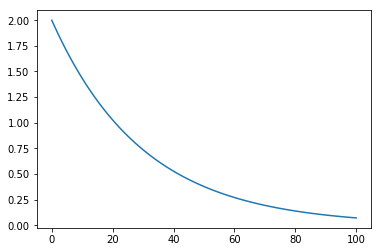

In [23]:
t = np.linspace(0,100,100)
sigma0 = 2
tau_sigma = 30
sigma = sigma0 * np.exp(-t/tau_sigma)
plt.plot(t,sigma)

## Now let's do the same using an autoencoder (that reduces dimensionality)

In [31]:
from keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, UpSampling2D, SeparableConv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras import backend as K


def Encoder():
    input_img = Input(shape=(3,))  # adapt this if using `channels_first` image data format   
    e1 = Dense(2, activation='linear')(input_img)
    e1 = BatchNormalization()(e1)
    return Model(input_img, e1, name='encoder')

def Decoder():
    input_img = Input(shape=(2,))  # adapt this if using `channels_first` image data format   
    e1 = Dense(3, activation='linear')(input_img)
    e1 = BatchNormalization()(e1)
    return Model(input_img, e1, name='decoder')

encoder = Encoder()
decoder = Decoder()

inpt = Input(shape=(3,))
autoenc = Model(inputs=inpt, outputs=decoder(encoder(inpt)))
autoenc.compile(optimizer='adam', loss='mse')
h = autoenc.fit(x_train, 
                x_train,
                epochs=200,
                batch_size=50,
                shuffle=True,
                verbose=1)

Epoch 1/200
400/400 [==============================] - 1s 1ms/step - loss: 1.7489
Epoch 2/200
400/400 [==============================] - 0s 70us/step - loss: 1.6744
Epoch 3/200
400/400 [==============================] - 0s 76us/step - loss: 1.5987
Epoch 4/200
400/400 [==============================] - 0s 76us/step - loss: 1.5173
Epoch 5/200
400/400 [==============================] - 0s 63us/step - loss: 1.4709
Epoch 6/200
400/400 [==============================] - 0s 84us/step - loss: 1.4073
Epoch 7/200
400/400 [==============================] - 0s 83us/step - loss: 1.3543
Epoch 8/200
400/400 [==============================] - 0s 84us/step - loss: 1.3240
Epoch 9/200
400/400 [==============================] - 0s 83us/step - loss: 1.2689
Epoch 10/200
400/400 [==============================] - 0s 78us/step - loss: 1.2369
Epoch 11/200
400/400 [==============================] - 0s 85us/step - loss: 1.1743
Epoch 12/200
400/400 [==============================] - 0s 89us/step - loss: 1.1449
Ep

400/400 [==============================] - 0s 98us/step - loss: 0.2584
Epoch 195/200
400/400 [==============================] - 0s 62us/step - loss: 0.2620
Epoch 196/200
400/400 [==============================] - 0s 76us/step - loss: 0.2662
Epoch 197/200
400/400 [==============================] - 0s 63us/step - loss: 0.2638
Epoch 198/200
400/400 [==============================] - 0s 67us/step - loss: 0.2622
Epoch 199/200
400/400 [==============================] - 0s 85us/step - loss: 0.2596
Epoch 200/200
400/400 [==============================] - 0s 89us/step - loss: 0.2554


Text(0.5,1,'In the latent 2D space, we see that the clusters are not separated at all')

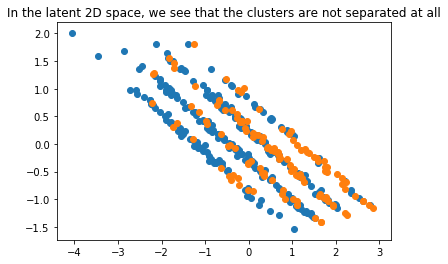

In [32]:
c1 = np.where(np.array(y_train)==0)[0]
c2 = np.where(np.array(y_train)==1)[0]
pred1 = encoder.predict(x_train[c1,:])
pred2 = encoder.predict(x_train[c2,:])
plt.scatter(pred1[:,0], pred1[:,1])
plt.scatter(pred2[:,0], pred2[:,1])
plt.title('In the latent 2D space, we see that the clusters are not separated at all')